## Imports

In [ ]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
import cv2
import os
import torchvision
import matplotlib.pyplot as plt 
from PIL import Image
from keras import backend as K

### Part 1b) Implement a filter to find vertical edges in an image and denoise an image.
---
Implement the function `detect_vertical_edges` below. This should apply a filter to detect vertical edges in the supplied input image. That is, your implementation should output a grayscale image of the same width and height as the input, with high values where vertical edges are present in the input image and low values elsewhere. Test your code on the supplied image.png. Display the input image and your output to demonstrate your implementation works correctly. Reminder: Your implementation of detect_vertical_edges should only use numpy. You may use other libraries to display your results.

Input image shape:  (512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output image shape:  (512, 512, 3)


[]

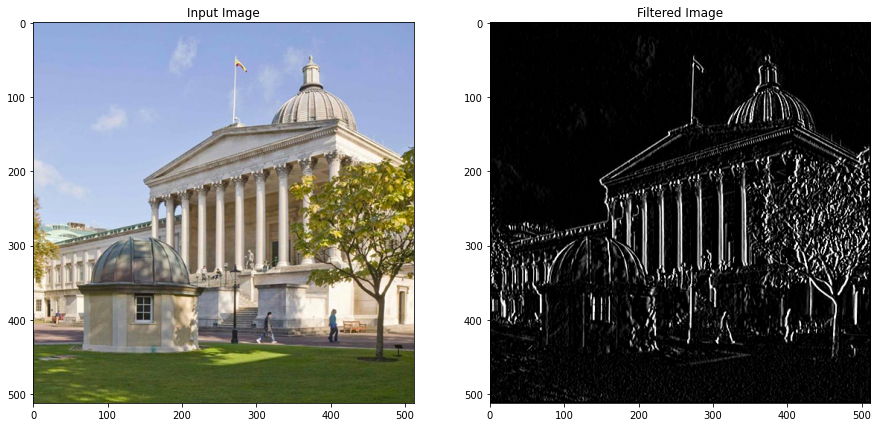

In [ ]:
input_image_filename = "../Datasets/Filtering/image.png"
input_image_filename = "image.png"

# LOAD input_image FROM input_image_filename
# As you specified above only the detection function has to be numpy
input_image = Image.open(input_image_filename)
# converting to RGB as the image has an aditional layer
# dividing by 255 to dormalise and remove distortion
input_image = np.array(input_image.convert('RGB')).astype(np.float) / 255.0
print("Input image shape: ",input_image.shape)

def detect_vertical_edges(image):
    # IMPLEMENT THIS FUNCTION

    # kernel based on sobel filter
    kernel = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]])

    # converting to greyscale using CRT weights
    # reference, page 7 : https://poynton.ca/PDFs/ColorFAQ.pdf
    greyImage = np.dot(image[...,:3], [0.299, 0.587, 0.114])

    # Adding padding of zeros around the image for convolution calculation
    paddedImage = np.array([np.append(0,i) for i in greyImage])
    paddedImage = np.array([np.append(i,0) for i in paddedImage])
    paddedImage = np.array([np.append(i,0) for i in paddedImage.T])
    paddedImage = (np.array([np.append(0,i) for i in paddedImage])).T

    # output image same shape as input
    filtered_image = np.zeros((image.shape))
    xKernel = kernel.shape[0] 
    yKernel = kernel.shape[1] 
    
    # going thorugh the image
    for y in range(image.shape[1]):
      if y > image.shape[1] - yKernel: 
        break
      for x in range(image.shape[0]):
        if x > image.shape[0] - xKernel: 
          break

        # convoluting the image and the kernel
        filtered_image[x, y] = (kernel * paddedImage[x: x + xKernel, y: y + yKernel]).sum() 
    
    # normalizing
    # filtered_image = filtered_image / np.max(filtered_image)

    return filtered_image

filtered_image = detect_vertical_edges(input_image)
print("Output image shape: ",filtered_image.shape)

# DISPLAY input_image AND filtered_image here
fig, axis = plt.subplots(1, 2, figsize = (15,15))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image, vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap="gray", vmin=np.min(filtered_image), vmax=np.max(filtered_image))
plt.plot()



Implement the `denoise_gauss` function below. This should apply a 5x5 gaussian filter to a supplied noisy image, returning an output of the same dimensions. Show results on the supplied noisy_image.png.

Reminder: Your implementation for denoise_gauss should only use numpy. You may use other libraries to display your results.

Input image size:  (512, 512, 3)
Padded image size:  (516, 516, 3)
Output image size:  (512, 512, 3)


[]

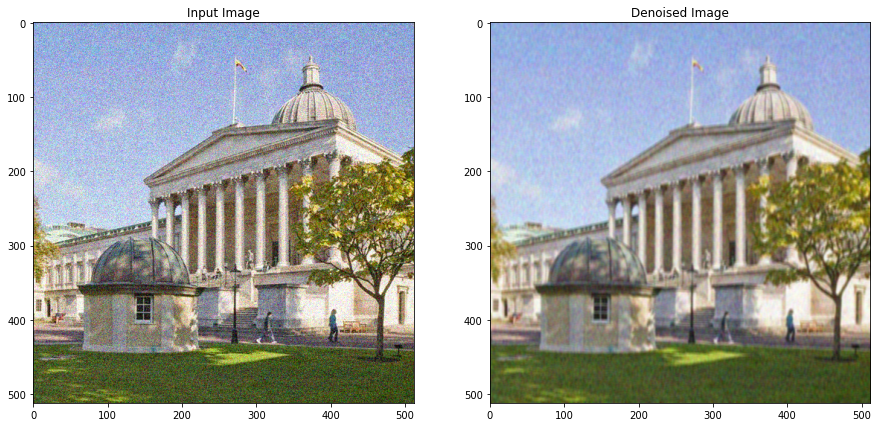

In [ ]:
noisy_image_filename = "../Datasets/Filtering/noisy_image.png"
noisy_image_filename = "noisy_image.png"

# LOAD noisy_image FROM noisy_image_filename
noisy_image = cv2.cvtColor(cv2.imread(noisy_image_filename), cv2.COLOR_BGR2RGB) / 255.0
print("Input image size: ",noisy_image.shape)

def denoise_gauss(image):
    # IMPLEMENT THIS FUNCTION

    # kernel based on integer aproximation of Gaussion
    # reference: https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm
    kernel = np.array([[1,  4,  7,  4, 1],
                       [4, 16, 26, 16, 4],
                       [7, 26, 41, 26, 7],
                       [4, 16, 26, 16, 4],
                       [1,  4,  7,  4, 1]])

    # Adding padding of zeros (zise 2) around the image for convolution calculation
    paddedImage = np.pad(image, ((2, 2), (2, 2), (0,0)), 'edge')
    print("Padded image size: ",paddedImage.shape)

    # splitting RGB image into its 3 channels to execure convulution on each separately
    r,g,b = np.split(paddedImage, 3, axis=2)

    # output image same shape as input
    denoised_image_r = np.zeros((image.shape[0],image.shape[1]))
    denoised_image_g = np.zeros((image.shape[0],image.shape[1]))
    denoised_image_b = np.zeros((image.shape[0],image.shape[1]))
    xKernShape = kernel.shape[0] 
    yKernShape = kernel.shape[1] 
    
    # going thorugh the image
    for y in range(image.shape[1]):
      for x in range(image.shape[0]):
        # convoluting the image and the kernel
        denoised_image_r[x, y] = (kernel * r[x: x + xKernShape, y: y + yKernShape]).sum()
        denoised_image_g[x, y] = (kernel * g[x: x + xKernShape, y: y + yKernShape]).sum()
        denoised_image_b[x, y] = (kernel * b[x: x + xKernShape, y: y + yKernShape]).sum()

    # normalizing the data
    denoised_image_r = denoised_image_r / np.max(denoised_image_r)
    denoised_image_g = denoised_image_g / np.max(denoised_image_g)
    denoised_image_b = denoised_image_b / np.max(denoised_image_b)

    # stacking all layers back to NxMx3 for RGB image
    denoised_image = np.dstack((denoised_image_r, denoised_image_g, denoised_image_b))
    return denoised_image

denoised_image = denoise_gauss(noisy_image)
print("Output image size: ",denoised_image.shape)

# DISPLAY input_image AND denoised_image here
fig, axis = plt.subplots(1, 2, figsize = (15,15))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(noisy_image, vmin=0 , vmax=1)
plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(denoised_image, vmin=0 , vmax=1)
plt.plot()